In [16]:
from __future__ import annotations
import os
import uuid
import chromadb
from matplotlib import pyplot as plt
# Import สิ่งที่จำเป็นจาก ChromaDB
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
from chromadb.utils.data_loaders import ImageLoader

In [6]:
# ---------------- Config ----------------
PERSIST_DIR = "./chroma_multimodal_local_dataloader" # เปลี่ยน path เพื่อไม่ให้ปนกับของเก่า
COLLECTION_NAME = "pets_local_dataloader"

DOG_IMAGES = ["images/dog1.png", "images/dog2.png", "images/dog3.png"]
CAT_IMAGES = ["images/cat1.png", "images/cat2.png", "images/cat3.png"]

In [7]:
# Step 1 - เตรียม path ของรูปและ metadata
all_image_paths = DOG_IMAGES + CAT_IMAGES
labels = ["dog"] * len(DOG_IMAGES) + ["cat"] * len(CAT_IMAGES)
doc_ids = [str(uuid.uuid4()) for _ in all_image_paths]

# --- ส่วนที่แก้ไข ---
# สร้าง document description
document_descriptions = [f"A photo of a {lbl}" for lbl in labels]
# เอามารวมใน metadatas แทน
metadatas = [
    {
        "label": lbl,
        "filename": os.path.basename(path),
        "description": desc # เพิ่ม description เข้าไปใน metadata
    }
    for lbl, path, desc in zip(labels, all_image_paths, document_descriptions)
]

In [9]:
# Step 2 - Setup ChromaDB Client
# ใช้ PersistentClient เพื่อให้บันทึกข้อมูลลงดิสก์
client = chromadb.PersistentClient(path=PERSIST_DIR)

# Step 3 - สร้าง/เรียกใช้ Collection โดยระบุ Embedding Function และ Data Loader
# ChromaDB จะใช้ OpenCLIP model ซึ่งเทียบเท่ากับ "clip-ViT-B-32" โดยอัตโนมัติ
collection = client.get_or_create_collection(
    name=COLLECTION_NAME,
    embedding_function=OpenCLIPEmbeddingFunction(), # บอกให้ใช้ OpenCLIP
    data_loader=ImageLoader(),                     # บอกให้ใช้ ImageLoader
    metadata={"hnsw:space": "cosine"}
)

In [11]:
print(all_image_paths)
print(metadatas)

['images/dog1.png', 'images/dog2.png', 'images/dog3.png', 'images/cat1.png', 'images/cat2.png', 'images/cat3.png']
[{'label': 'dog', 'filename': 'dog1.png', 'description': 'A photo of a dog'}, {'label': 'dog', 'filename': 'dog2.png', 'description': 'A photo of a dog'}, {'label': 'dog', 'filename': 'dog3.png', 'description': 'A photo of a dog'}, {'label': 'cat', 'filename': 'cat1.png', 'description': 'A photo of a cat'}, {'label': 'cat', 'filename': 'cat2.png', 'description': 'A photo of a cat'}, {'label': 'cat', 'filename': 'cat3.png', 'description': 'A photo of a cat'}]


In [12]:
# Step 4 - เพิ่มรูปเข้า DB โดยใช้ URIs
# ไม่ต้องแปลงรูปเป็น embedding เองแล้ว! แค่ส่ง path ของไฟล์ไป
collection.add(
    ids=doc_ids,
    uris=all_image_paths, # <--- จุดสำคัญคือตรงนี้
    metadatas=metadatas
)
print(f"Indexed {len(doc_ids)} images into collection '{collection.name}'.")

Indexed 6 images into collection 'pets_local_dataloader'.


In [14]:
# ไม่ต้องแปลง query เป็น embedding เองเช่นกัน
query_text = "dog"
res = collection.query(
  query_texts=[query_text], # <--- ส่งข้อความ query เข้าไปตรงๆ
  n_results=2,
  include=["metadatas", "documents", "distances"]
)
res

{'ids': [['940e7f10-81ec-42ce-99dd-1b7b51ce1054',
   '464ac875-dc33-43b8-a38e-1e0581a22a2a']],
 'embeddings': None,
 'documents': [[None, None]],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'label': 'dog',
    'description': 'A photo of a dog',
    'filename': 'dog1.png'},
   {'filename': 'dog2.png',
    'description': 'A photo of a dog',
    'label': 'dog'}]],
 'distances': [[0.7248085737228394, 0.7344670295715332]]}

In [15]:
# Step 5 - ทดสอบ Query ด้วยข้อความ
# ไม่ต้องแปลง query เป็น embedding เองเช่นกัน
query_text = "dog"
res = collection.query(
  query_texts=[query_text], # <--- ส่งข้อความ query เข้าไปตรงๆ
  n_results=4,
  include=["metadatas", "documents", "distances"]
)

# แสดงผลลัพธ์
print(f"\n=== Query: '{query_text}' ===")
for rank, (meta, doc, dist) in enumerate(zip(res["metadatas"][0], res["documents"][0], res["distances"][0]), start=1):
  print(f"#{rank} -> {meta['filename']} ({meta['label']}) distance={dist:.4f}")
  print("desc:", doc)


=== Query: 'dog' ===
#1 -> dog1.png (dog) distance=0.7248
desc: None
#2 -> dog2.png (dog) distance=0.7345
desc: None
#3 -> dog3.png (dog) distance=0.7376
desc: None
#4 -> cat1.png (cat) distance=0.7784
desc: None



=== Query: 'dog' ===
#1 -> dog1.png (dog) distance=0.7248
desc: None


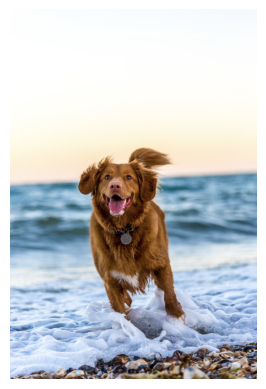


#2 -> dog2.png (dog) distance=0.7345
desc: None


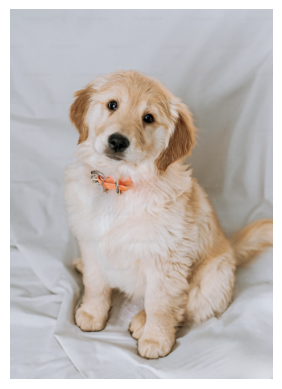


#3 -> dog3.png (dog) distance=0.7376
desc: None


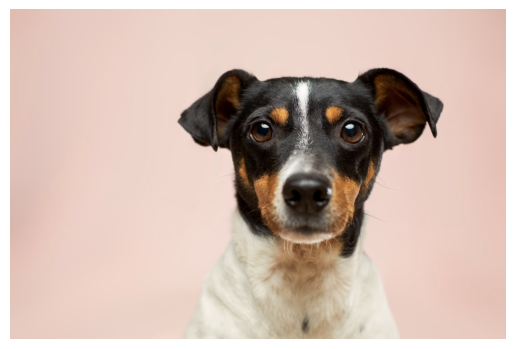


#4 -> cat1.png (cat) distance=0.7784
desc: None


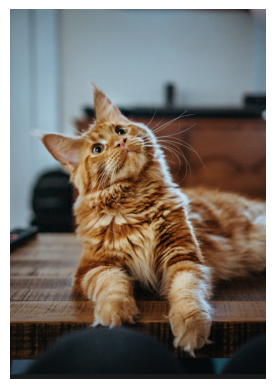

In [34]:
query_text = "dog"
res = collection.query(
  query_texts=[query_text], # <--- ส่งข้อความ query เข้าไปตรงๆ
  n_results=4,
  include=["metadatas", "documents", "distances", "data"]
)

# แสดงผลลัพธ์
print(f"\n=== Query: '{query_text}' ===")
for rank, (img, meta, doc, dist) in enumerate(zip(res['data'][0], res["metadatas"][0], res["documents"][0], res["distances"][0]), start=1):
    print(f"#{rank} -> {meta['filename']} ({meta['label']}) distance={dist:.4f}")
    print("desc:", doc)
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    print()


In [33]:
    
print("Type of res['data']:", type(res['data']))
print("Length of res['data']:", len(res['data']))
print("Type of res['data'][0]:", type(res['data'][0]))
print("Length of res['data'][0]:", len(res['data'][0]))
print(res['data'][0])

Type of res['data']: <class 'list'>
Length of res['data']: 1
Type of res['data'][0]: <class 'list'>
Length of res['data'][0]: 4
[array([[[252, 254, 255, 255],
        [252, 254, 255, 255],
        [252, 254, 255, 255],
        ...,
        [244, 250, 253, 255],
        [244, 250, 253, 255],
        [244, 250, 253, 255]],

       [[252, 254, 255, 255],
        [252, 254, 255, 255],
        [252, 254, 255, 255],
        ...,
        [244, 250, 253, 255],
        [244, 250, 253, 255],
        [244, 250, 253, 255]],

       [[252, 254, 255, 255],
        [252, 254, 255, 255],
        [252, 254, 255, 255],
        ...,
        [244, 250, 253, 255],
        [244, 250, 253, 255],
        [244, 250, 253, 255]],

       ...,

       [[156, 174, 210, 255],
        [158, 171, 209, 255],
        [153, 160, 200, 255],
        ...,
        [108,  92,  87, 255],
        [133, 117,  99, 255],
        [159, 145, 109, 255]],

       [[147, 166, 200, 255],
        [148, 163, 199, 255],
        [140, 151,